In [ ]:
import random
from torchvision.transforms import functional as F

class RandomizedResize:
    def __init__(self, scale_range=(0.5, 1.5)):
        """
        Args:
            scale_range (tuple): A tuple specifying the min and max scale factors (default: (0.5, 1.5)).
        """
        self.scale_range = scale_range

    def __call__(self, image, mask):
        """
        Randomly resizes the image and mask within the specified scale range.

        Args:
            image (PIL Image): The input image.
            mask (PIL Image): The corresponding mask.

        Returns:
            (PIL Image, PIL Image): The resized image and mask.
        """
        # Generate a random scale factor within the scale range
        scale_factor = random.uniform(*self.scale_range)
        print(scale_factor)
        
        print("Original Image Size: ", image.size)
        print("Origina Mask Size: ", mask.size)

        # Compute new dimensions
        new_width = int(image.width * scale_factor)
        new_height = int(image.height * scale_factor)
        print("Resizing by a factor of ", scale_factor)


        # Resize both the image and the mask
        image = F.resize(image, (new_height, new_width), interpolation=F.InterpolationMode.BILINEAR)
        mask = F.resize(mask, (new_height, new_width), interpolation=F.InterpolationMode.NEAREST)
        print("New Image Size: ", image.size)
        print("New Mask Size: ", mask.size)
        return image, mask


: 

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Define the RGB mapping for each label
LABEL_TO_RGB = {
    0: (0, 0, 0),          # Black - Sea Surface
    1: (0, 255, 255),      # Cyan  - Oil Spill
    2: (255, 0, 0),        # Red   - Look-alike
    3: (153, 76, 0),       # Brown - Ship
    4: (0, 153, 0)         # Green - Land
}

def label_to_rgb(mask):
    # Create an empty RGB image
    height, width = mask.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Map each label to its corresponding RGB value
    for label, color in LABEL_TO_RGB.items():
        rgb_image[mask == label] = color

    return rgb_image

1.2345084424873147
Original Image Size:  (1250, 650)
Origina Mask Size:  (1250, 650)
Resizing by a factor of  1.2345084424873147
New Image Size:  (1543, 802)
New Mask Size:  (1543, 802)


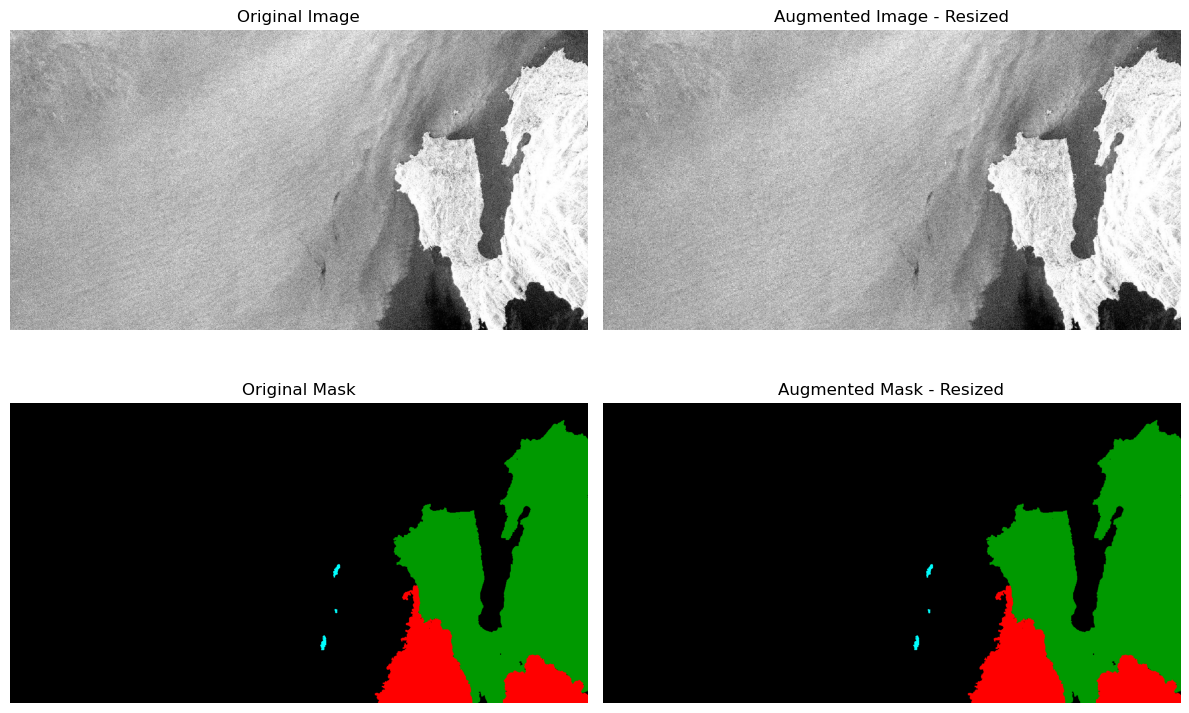

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Instantiate the random resize augmentation
random_resize = RandomizedResize()

# Define a sample image and mask
image_path = "../dataset/train/images/img_0212.jpg"
mask_path = "../dataset/train/labels_1D/img_0212.png"

# Load the image and mask
image = Image.open(image_path).convert("RGB")
mask = Image.open(mask_path).convert("L")

# Apply the random resizing augmentation
augmented_image, augmented_mask = random_resize(image, mask)

# Convert the mask to RGB for visualization
original_mask_rgb = label_to_rgb(np.array(mask))
augmented_mask_rgb = label_to_rgb(np.array(augmented_mask))

# =================== RESULTS ===================

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Original image
axs[0, 0].imshow(np.array(image))
axs[0, 0].set_title("Original Image")
# Original mask
axs[1, 0].imshow(original_mask_rgb)
axs[1, 0].set_title("Original Mask")
# Augmented image
axs[0, 1].imshow(np.array(augmented_image))
axs[0, 1].set_title(f"Augmented Image - Resized")
# Augmented mask
axs[1, 1].imshow(augmented_mask_rgb)
axs[1, 1].set_title(f"Augmented Mask - Resized")

# Remove axis ticks
for ax in axs.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()


## Test

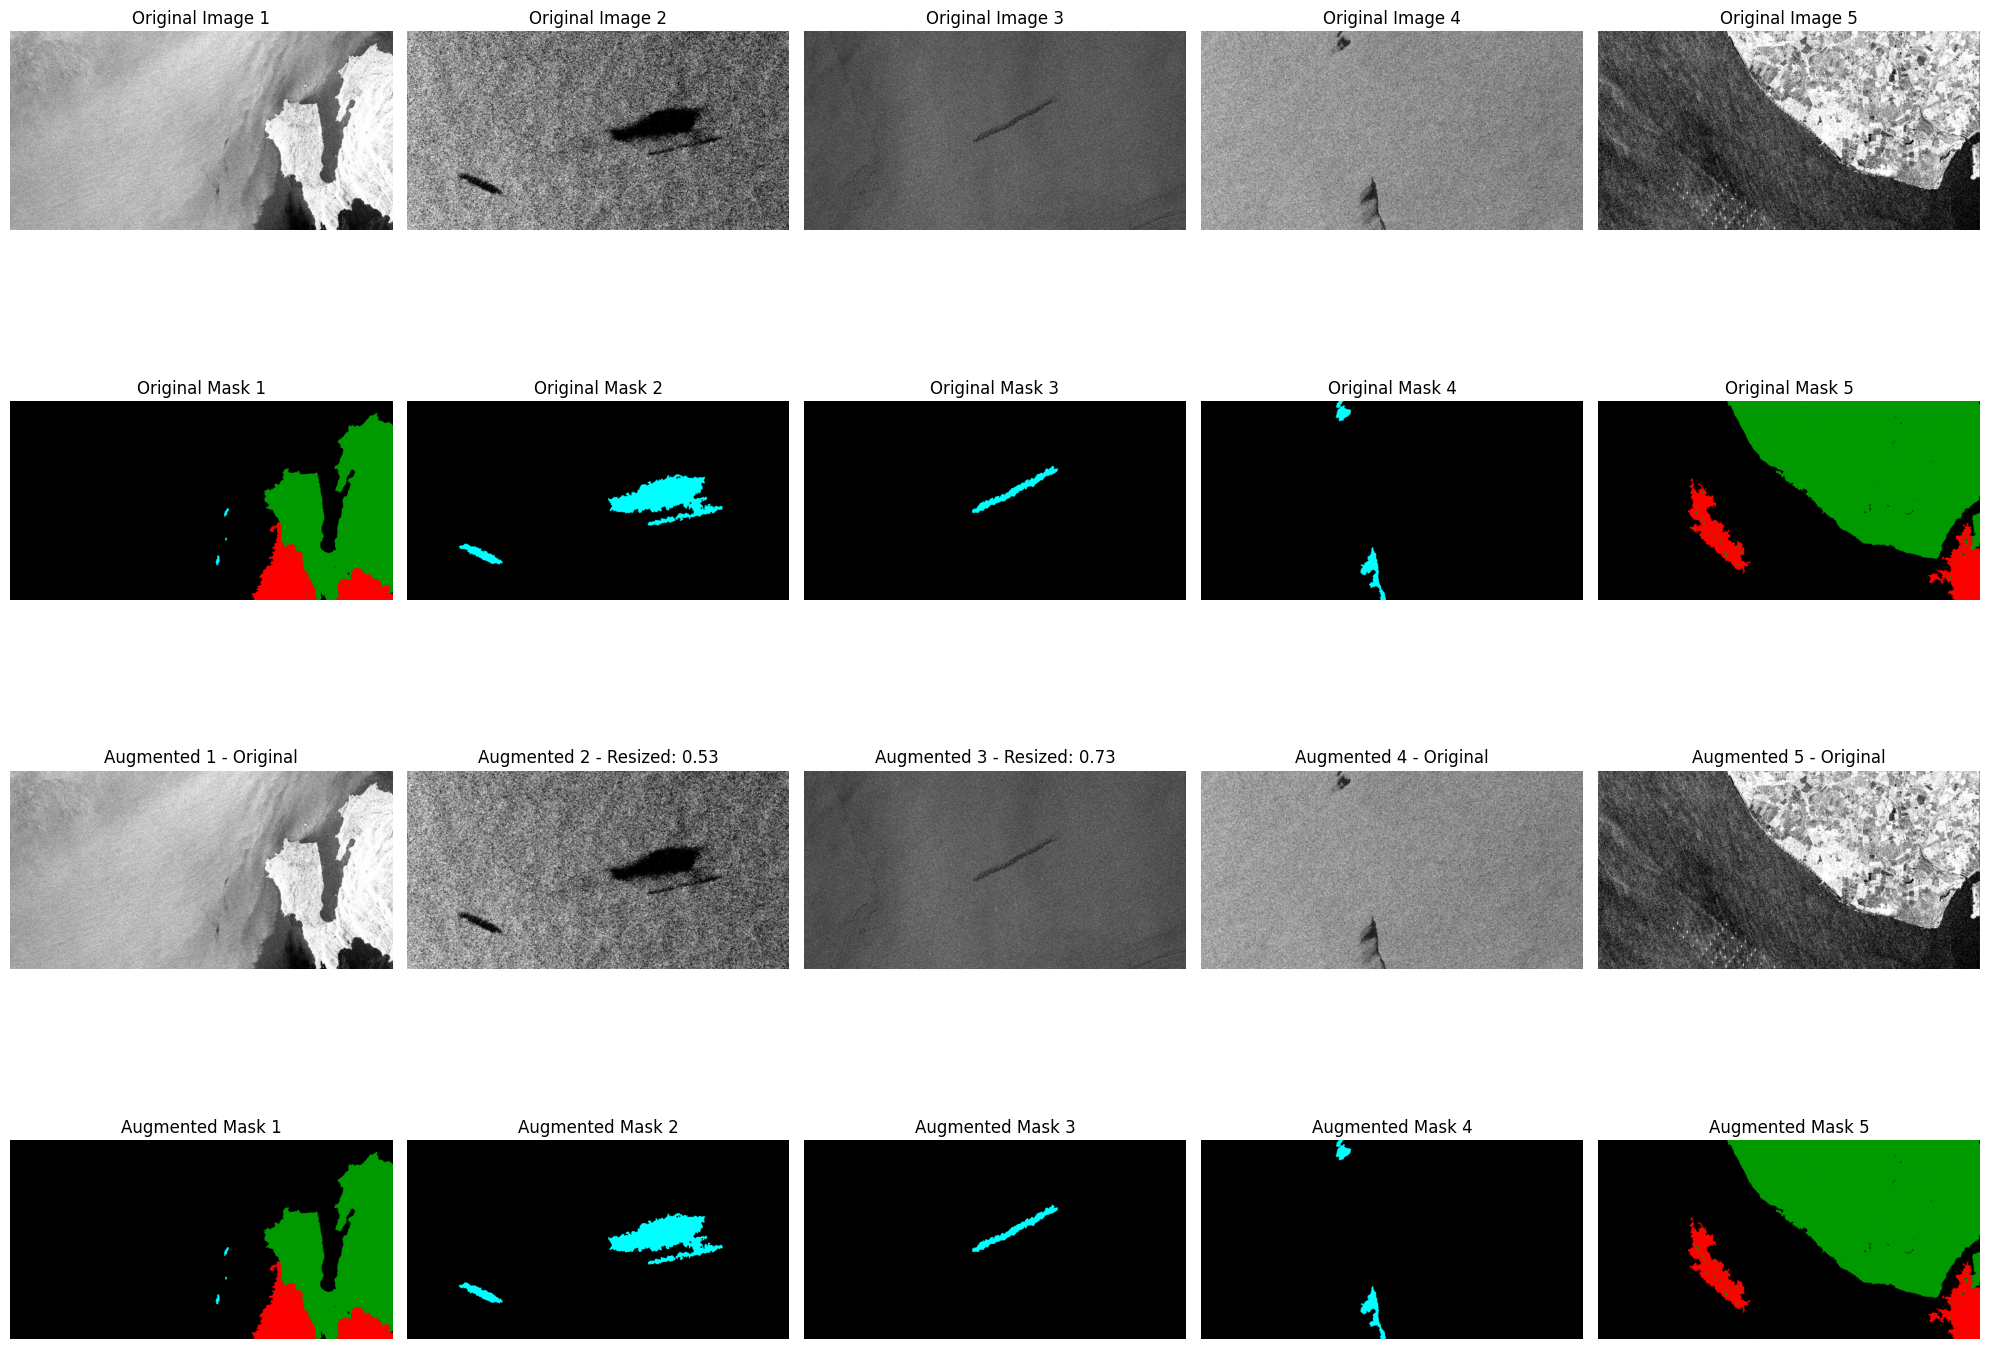

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

class ProbabilisticRandomizedResize:
    def __init__(self, resize_augment, probability=0.5):
        """
        Wraps the RandomizedResize class with a probabilistic application.
        Args:
            resize_augment (RandomizedResize): The RandomizedResize augmentation instance.
            probability (float): Probability of applying the augmentation.
        """
        self.resize_augment = resize_augment
        self.probability = probability

    def __call__(self, image, mask):
        """
        Applies the RandomizedResize augmentation with a probability.
        Args:
            image (PIL Image): The input image.
            mask (PIL Image): The corresponding mask.
        Returns:
            (PIL Image, PIL Image, bool, float): The augmented image, mask, a flag indicating if augmentation was applied,
                                                 and the resize factor (1.0 if not resized).
        """
        if random.random() < self.probability:
            scale_factor = random.uniform(*self.resize_augment.scale_range)  # Randomly select a scale factor
            image = image.resize((int(image.width * scale_factor), int(image.height * scale_factor)))
            mask = mask.resize((int(mask.width * scale_factor), int(mask.height * scale_factor)), resample=Image.NEAREST)
            return image, mask, True, scale_factor
        return image, mask, False, 1.0



random_resize = RandomizedResize(scale_range=(0.5, 1.5))
prob_random_resize = ProbabilisticRandomizedResize(random_resize, probability=0.5)

# Define paths to 5 sample images and masks
image_paths = [
    "../dataset/train/images/img_0212.jpg",
    "../dataset/train/images/img_0213.jpg",
    "../dataset/train/images/img_0214.jpg",
    "../dataset/train/images/img_0215.jpg",
    "../dataset/train/images/img_0216.jpg"
]

mask_paths = [
    "../dataset/train/labels_1D/img_0212.png",
    "../dataset/train/labels_1D/img_0213.png",
    "../dataset/train/labels_1D/img_0214.png",
    "../dataset/train/labels_1D/img_0215.png",
    "../dataset/train/labels_1D/img_0216.png"
]


# Load images and masks
images = [Image.open(path).convert("RGB") for path in image_paths]
masks = [Image.open(path).convert("L") for path in mask_paths]

# Apply augmentation with 50% probability to all images
augmented_images = []
augmented_masks = []
resize_factors = []
is_resized_list = []

for img, mask in zip(images, masks):
    aug_img, aug_mask, is_resized, resize_factor = prob_random_resize(img, mask)
    augmented_images.append(np.array(aug_img))
    augmented_masks.append(label_to_rgb(np.array(aug_mask)))
    is_resized_list.append(is_resized)
    resize_factors.append(resize_factor)

# =================== RESULTS ===================

fig, axs = plt.subplots(4, len(images), figsize=(20, 16))

# Plot the original and augmented images and masks
for i in range(len(images)):
    # Original image
    axs[0, i].imshow(np.array(images[i]))
    axs[0, i].set_title(f"Original Image {i + 1}")
    # Original mask
    axs[1, i].imshow(label_to_rgb(np.array(masks[i])))
    axs[1, i].set_title(f"Original Mask {i + 1}")
    # Augmented image with resize factor in the title if resized
    title_suffix = f"Resized: {resize_factors[i]:.2f}" if is_resized_list[i] else "Original"
    axs[2, i].imshow(augmented_images[i])
    axs[2, i].set_title(f"Augmented {i + 1} - {title_suffix}")
    # Augmented mask
    axs[3, i].imshow(augmented_masks[i])
    axs[3, i].set_title(f"Augmented Mask {i + 1}")

# Remove axis ticks
for ax in axs.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()
